# Using Hill Climbing to find food

In [1]:
from aitk.robots import World, Scribbler, SmellSensor, __version__
__version__

'0.9.23'

In [2]:
world = World(width=200, height=200, scale=2, boundary_wall=False)
world.add_food(100, 100, 70)

Random seed set to: 621261


In [3]:
robot = Scribbler(x=110, y=150, a=50)
robot.add_device(SmellSensor(position=(8,0),name="nose"))
robot.set_max_trace_length(60)
world.add_robot(robot)
world.update()

In [4]:
from random import random

In [5]:
def init_state(robot):
    robot.state['behavior'] = 'test'
    robot.state['max_step'] = 5
    robot.state['current'] = 0
    robot.state['step'] = 0
    robot.state['rotation'] = 0

In [9]:
def controller(robot):
    if robot.eat():
        # Try to eat, if successful end run
        return True
    elif robot.state['behavior'] == 'test':
        # Check current smell and choose a random rotation to try
        robot.state['current'] = robot['nose'].get_reading()
        robot.state['rotation'] = random()-0.5
        robot.move(0, robot.state['rotation'])
        robot.state['behavior'] = 'turn'
    elif robot.state['behavior'] == 'turn':
        # Turn for max_steps, then check new smell
        if robot.state['step'] % robot.state['max_step'] == 0:
            next_reading = robot['nose'].get_reading()
            delta = next_reading - robot.state['current']
            if delta > 0:
                # if smell is stronger, go forward
                robot.move(0.5, 0)
                robot.state['behavior'] = 'forward'
            else:
                # if smell is weaker, reverse turn and try again
                robot.move(0, -1*robot.state['rotation'])
                robot.state['behavior'] = 'reverse'
    elif robot.state['behavior'] == 'reverse':
        # Reverse rotation for max_steps, then go back to testing
        if robot.state['step'] % robot.state['max_step'] == 0:
            robot.stop()
            robot.state['behavior'] = 'test'
    elif robot.state['behavior'] == 'forward':
        # Move forward for max_steps, then go back to testing
        if robot.state['step'] % robot.state['max_step'] == 0:
            robot.stop()
            robot.state['behavior'] = 'test'
    robot.state['step'] += 1

In [10]:
world.reset()
robot.set_random_pose()
init_state(robot)
recorder = world.record()
world.run([controller],real_time=False)

Random seed set to: 2515546
Using random seed: 621261
Using random seed: 621261
Simulation stopped at: 00:01:11.1; speed 1213.75 x real time


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Player(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, continuous_update=False, description='Ti…

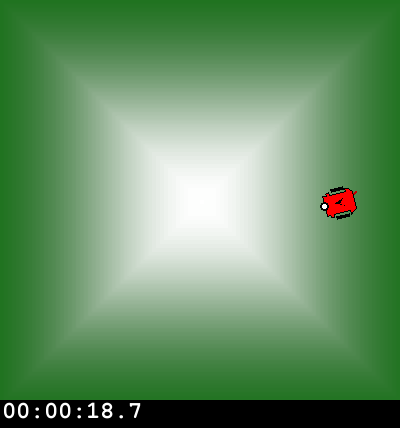

In [11]:
recorder.watch()